In [16]:
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings("ignore")

In [17]:
df = pd.read_csv("Coded_Segments.csv")
print(df.head())

               Dokumentname         Code  Anfang  Ende  \
0  reflection_assignment_P1      Level 1       1     1   
1  reflection_assignment_P1      Level 1       1     1   
2  reflection_assignment_P1      Level 1       1     1   
3  reflection_assignment_P1  Level 2 (a)       1     1   
4  reflection_assignment_P1  Level 2 (a)       1     1   

                                             Segment  
0  I am a newbie in data science (DS). On the one...  
1  However, the handling of data in basic cogniti...  
2  The HCDS course was largely aimed at a critica...  
3  Among these topics, some messages particularly...  
4  First of all, I became aware of the importance...  


In [18]:
df['Code'].value_counts()

Code
Level 3        90
Level 1        69
Level 2 (b)    41
Level 2 (a)    31
Level 4         6
Name: count, dtype: int64

(array([69.,  0., 31.,  0.,  0., 41.,  0., 90.,  0.,  6.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

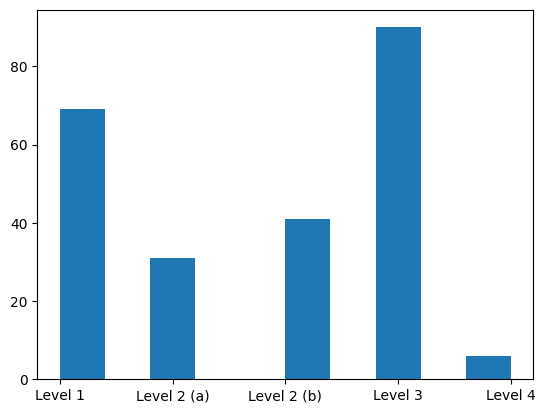

In [19]:
plt.hist(sorted(df['Code']))

In [20]:
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    le = LabelEncoder()
    df['class'] = le.fit_transform(df['Code'])

    # handle imbalanced dataset
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(df[['Segment']], df['class'])
    df_resampled = pd.DataFrame({'Segment': X_resampled['Segment'], 'class': y_resampled})

    print(f"Original dataset shape: {df.shape}")
    print(f"Resampled dataset shape: {df_resampled.shape}")

    return df_resampled, le

In [21]:
df_resampled, label_encoder = preprocess_data(df)
print(df_resampled)

Original dataset shape: (237, 6)
Resampled dataset shape: (450, 2)
                                               Segment  class
0    I am a newbie in data science (DS). On the one...      0
1    However, the handling of data in basic cogniti...      0
2    The HCDS course was largely aimed at a critica...      0
3    Among these topics, some messages particularly...      1
4    First of all, I became aware of the importance...      1
..                                                 ...    ...
445  The first concern, to begin  with, is to check...      4
446  The first concern, to begin  with, is to check...      4
447  Social nuances have shown how important it is ...      4
448  It also made me realise the high personal resp...      4
449  As an when my experience grew, I started to un...      4

[450 rows x 2 columns]


In [22]:
df_resampled['class'].value_counts()

class
0    90
1    90
4    90
2    90
3    90
Name: count, dtype: int64

(array([90.,  0., 90.,  0.,  0., 90.,  0., 90.,  0., 90.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

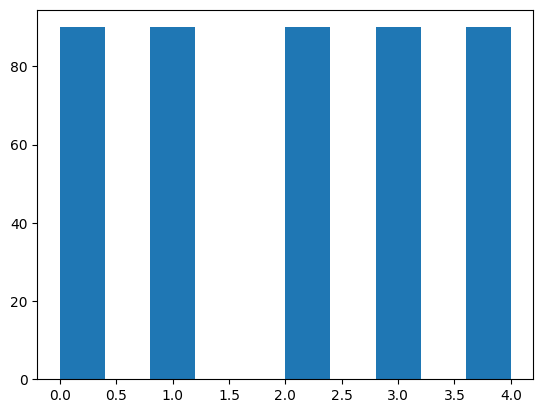

In [23]:
plt.hist(sorted(df_resampled['class']))

Validation Set Results:
Accuracy: 0.90
Cohen's Kappa: 0.87
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.85      0.88        13
           1       0.93      1.00      0.97        14
           2       0.86      0.92      0.89        13
           3       0.75      0.69      0.72        13
           4       1.00      1.00      1.00        14

    accuracy                           0.90        67
   macro avg       0.89      0.89      0.89        67
weighted avg       0.89      0.90      0.89        67



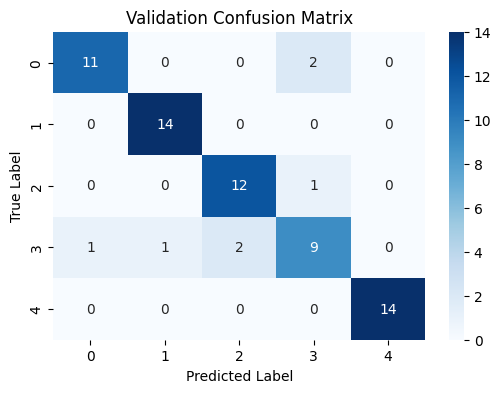


Test Set Results:
Accuracy: 0.91
Cohen's Kappa: 0.89
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       0.92      0.85      0.88        13
           2       0.87      0.93      0.90        14
           3       0.85      0.79      0.81        14
           4       1.00      1.00      1.00        13

    accuracy                           0.91        68
   macro avg       0.91      0.91      0.91        68
weighted avg       0.91      0.91      0.91        68



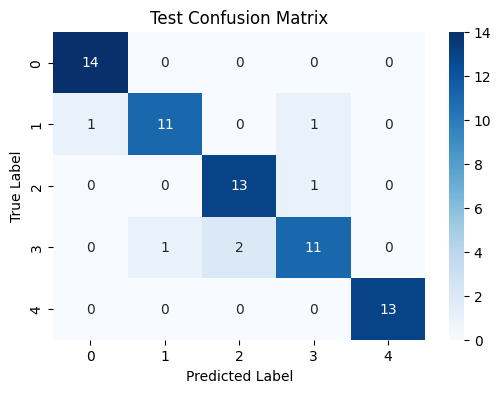

In [24]:
# Preprocessing
# Split into training, validation and test sets
train_df, temp_df = train_test_split(df_resampled, test_size=0.3, stratify=df_resampled['class'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['class'], random_state=42)

# Extract text and labels
X_train, y_train = train_df['Segment'], train_df['class']
X_val, y_val = val_df['Segment'], val_df['class']
X_test, y_test = test_df['Segment'], test_df['class']

# Convert text to numerical features using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 1), max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

# Train a Logistic Regression classifier
logreg_model = LogisticRegression(max_iter=1000, random_state=42)
logreg_model.fit(X_train_tfidf, y_train)

# Evaluate on validation and test sets
lr_y_val_pred = logreg_model.predict(X_val_tfidf)
lr_y_test_pred = logreg_model.predict(X_test_tfidf)

# Metrics for validation set
lr_val_accuracy = accuracy_score(y_val, lr_y_val_pred)
lr_val_class_report = classification_report(y_val, lr_y_val_pred, zero_division=0)
lr_val_cohen_kappa = cohen_kappa_score(y_val, lr_y_val_pred)
lr_val_cm = confusion_matrix(y_val, lr_y_val_pred)

# Metrics for test set
lr_test_accuracy = accuracy_score(y_test, lr_y_test_pred)
lr_test_class_report = classification_report(y_test, lr_y_test_pred, zero_division=0)
lr_test_cohen_kappa = cohen_kappa_score(y_test, lr_y_test_pred)
lr_test_cm = confusion_matrix(y_test, lr_y_test_pred)

# Print results
print("Validation Set Results:")
print(f"Accuracy: {lr_val_accuracy:.2f}")
print(f"Cohen's Kappa: {lr_val_cohen_kappa:.2f}")
print("Classification Report:")
print(lr_val_class_report)
plt.figure(figsize=(6,4))
sns.heatmap(lr_val_cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y_val)), yticklabels=sorted(set(y_val)))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Validation Confusion Matrix")
plt.show()

print("\nTest Set Results:")
print(f"Accuracy: {lr_test_accuracy:.2f}")
print(f"Cohen's Kappa: {lr_test_cohen_kappa:.2f}")
print("Classification Report:")
print(lr_test_class_report)
plt.figure(figsize=(6,4))
sns.heatmap(lr_test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Test Confusion Matrix")
plt.show()

In [25]:
# Get the feature names (words) from the TF-IDF vectorizer
feature_names = np.array(vectorizer.get_feature_names_out())

# Get the feature importance (coefficients)
class_feature_coefs = logreg_model.coef_

# For each class, find the most important words
for class_idx, class_coefs in enumerate(class_feature_coefs):
    print(f"\nTop words for class {class_idx}:")

    # Get the indices of the top 10 words (sorted by importance)
    top10_idx = class_coefs.argsort()[-10:][::-1]

    # Display the words and their importance
    for idx in top10_idx:
        print(f"{feature_names[idx]}: {class_coefs[idx]:.4f}")


Top words for class 0:
model: 0.6468
our: 0.6306
we: 0.5792
data: 0.5396
improve: 0.5375
processing: 0.5064
principles: 0.4459
workflow: 0.4322
lectures: 0.4277
achieve: 0.4105

Top words for class 1:
science: 0.7233
constant: 0.7190
human: 0.7037
assignments: 0.6740
must: 0.6210
became: 0.5990
concepts: 0.5756
needs: 0.5632
thank: 0.5518
nice: 0.5518

Top words for class 2:
was: 1.0213
me: 0.7762
fairness: 0.7444
as: 0.6346
this: 0.6168
licensing: 0.6136
course: 0.6029
because: 0.6023
learnt: 0.5934
tool: 0.5377

Top words for class 3:
would: 1.0862
making: 0.7020
concepts: 0.6405
decision: 0.6347
them: 0.5903
my: 0.5648
make: 0.5458
we: 0.5260
other: 0.4976
practice: 0.4932

Top words for class 4:
to: 1.0906
social: 1.0633
is: 1.0377
document: 0.9702
that: 0.9187
of: 0.7998
society: 0.7832
impact: 0.7691
responsibility: 0.7638
if: 0.7481


In [26]:
# Get the average feature importance across all classes
global_feature_importance = np.mean(np.abs(class_feature_coefs), axis=0)

# Get the top 20 most important features globally
top20_global_idx = global_feature_importance.argsort()[-20:][::-1]

print("\nGlobal Top 20 Important Words:")
for idx in top20_global_idx:
    print(f"{feature_names[idx]}: {global_feature_importance[idx]:.4f}")


Global Top 20 Important Words:
to: 0.5061
concepts: 0.4864
would: 0.4699
me: 0.4578
that: 0.4520
the: 0.4467
we: 0.4421
was: 0.4391
social: 0.4253
this: 0.4231
is: 0.4151
document: 0.4082
of: 0.4030
will: 0.4026
have: 0.4018
science: 0.3927
not: 0.3924
but: 0.3566
as: 0.3501
data: 0.3377
